In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

from custom_models import get_cell_based_tiny_net
from custom_search_cells import NAS201SearchCell as SearchCell
from xautodl.models.cell_searchs.genotypes import Structure

# NB201
from nas_201_api import NASBench201API as API

import scipy.stats as stats
from tqdm import tqdm

2022-11-07 07:10:46.570516: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./op_level-use_pretrain', help="Folder to save checkpoints and log.")
# parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--arch_nas_dataset", type=str, default=None, help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

24382
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=24382, save_dir='./op_level-use_pretrain', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=op_level-use_pretrain, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 24382
save_dir         : ./op_level-use_pretrain
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
# if xargs.arch_nas_dataset is None:
api = None
# else:
#     api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=50, current::epoch=0, iter=0.00, type=cosine, T-max=50, eta-min=0.001)
criterion   : CrossEntropyLoss(

In [5]:
def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
                
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
#     inputs, targets = inputs[:64], targets[:64] # smaller batches
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 100
        raise RuntimeError
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

In [6]:
supernet_weights = torch.load("./250ep_cosine_supernet_cell_wise.pth")
network.load_state_dict(supernet_weights)

<All keys matched successfully>

In [7]:
# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)

################# initialize
cells = []
for m in network.modules():
    if isinstance(m, SearchCell):
        cells.append(m)
num_cells = len(cells)
print("total number of nodes:{}".format(num_cells*xargs.max_nodes))
        
op_names = deepcopy(cells[0].op_names)
op_names_wo_none = deepcopy(op_names)
if "none" in op_names_wo_none:
    op_names_wo_none.remove("none")

genotypes = []
for i in range(1, xargs.max_nodes):
    xlist = []
    for j in range(i):
        node_str = "{:}<-{:}".format(i, j)
        if i-j==1:
            op_name = "skip_connect"
        else:
            op_name = "none"
        xlist.append((op_name, j))
    genotypes.append(tuple(xlist))
init_arch = Structure(genotypes)

for c in cells:
    c.arch_cache = init_arch

### gen possible connections of a target node
possible_connections = {}
for target_node_idx in range(1,xargs.max_nodes):
    possible_connections[target_node_idx] = list()
    xlists = []
    for src_node in range(target_node_idx):
        node_str = "{:}<-{:}".format(target_node_idx, src_node)
        # select possible ops
        if target_node_idx - src_node == 1:
            op_names_tmp = op_names_wo_none
        else:
            op_names_tmp = op_names
#         op_names_tmp = op_names
            
        if len(xlists) == 0: # initial iteration
            for op_name in op_names_tmp:
                xlists.append([(op_name, src_node)])
        else:
            new_xlists = []
            for op_name in op_names_tmp:
                for xlist in xlists:
                    new_xlist = deepcopy(xlist)
                    new_xlist.append((op_name, src_node))
                    new_xlists.append(new_xlist)
            xlists = new_xlists
    for xlist in xlists:
        selected_ops = []
        for l in xlist:
            selected_ops.append(l[0])
#         if sum(np.array(selected_ops) == "none") == len(selected_ops):
#             continue
        possible_connections[target_node_idx].append(tuple(xlist))
    print("target_node:{}".format(target_node_idx), len(possible_connections[target_node_idx]))
        
### train while generating random architectures by mutating connections of a target node

for arch_loop in range(3):
    logger.log("arch loop#{}, current structure:".format(arch_loop))
    for m in search_model.modules():
        if isinstance(m, SearchCell):
            logger.log(m.arch_cache)
    for target_cell_idx in range(num_cells):
        target_cell = cells[target_cell_idx]
        print("\n\n Searching with a cell #{}".format(target_cell_idx))
        for target_node_idx in range(1,xargs.max_nodes):
            current_genotypes,_ = target_cell.arch_cache.tolist(None)
            print("\nCurrent target cell:{} / current target node:{}".format(target_cell_idx, target_node_idx))
            ####
#             for src_node_idx in range(target_node_idx):
#                 node_str = "{:}<-{:}".format(target_node_idx, src_node_idx)
#                 for m in target_cell.edges[node_str].modules():
#                     if hasattr(m, 'reset_parameters'):
#                         m.reset_parameters()
            ####
            ## training
#             for ep in range(2):
#                 data_time, batch_time = AverageMeter(), AverageMeter()
#                 base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
#                 network.train()
#                 end = time.time()
#                 print_freq = 200
#                 for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(search_loader):
#                     ######### random generation
#                     genotypes = deepcopy(current_genotypes)
#                     connection = random.choice(possible_connections[target_node_idx])
#                     genotypes[target_node_idx-1] = connection
#                     arch = Structure(genotypes)
#                     target_cell.arch_cache = arch

#                     ######### forward/backward/optim
#                     base_targets = base_targets.cuda(non_blocking=True)
#                     arch_targets = arch_targets.cuda(non_blocking=True)
#                     # measure data loading time
#                     data_time.update(time.time() - end)
#                     w_optimizer.zero_grad()
#                     _, logits = network(base_inputs)
#                     base_loss = criterion(logits, base_targets)
#                     base_loss.backward()
#                     nn.utils.clip_grad_norm_(network.parameters(), 5)
#                     w_optimizer.step()

#                     ######### logging
#                     base_prec1, base_prec5 = obtain_accuracy(logits.data, base_targets.data, topk=(1, 5))
#                     base_losses.update(base_loss.item(), base_inputs.size(0))
#                     base_top1.update(base_prec1.item(), base_inputs.size(0))
#                     base_top5.update(base_prec5.item(), base_inputs.size(0))
#                     batch_time.update(time.time() - end)
#                     end = time.time()
#                     if step % print_freq == 0 or step + 1 == len(search_loader):
#                         Sstr = ("*Train* "+ time_string()+" Ep:{:} [{:03d}/{:03d}]".format(ep, step, len(search_loader)))
#                         Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(batch_time=batch_time, data_time=data_time)
#                         Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(loss=base_losses, top1=base_top1, top5=base_top5)
#                         logger.log(Sstr + " " + Tstr + " " + Wstr)

#                 logger.log("Ep:{:} ends : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(ep, base_losses.avg, base_top1.avg, base_top5.avg))
            ## evaluation
            network.train()
            archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
            loader_iter = iter(valid_loader)
            for connection in tqdm(possible_connections[target_node_idx]):
                ###### traverse over possible archs
                genotypes = deepcopy(current_genotypes)
                genotypes[target_node_idx-1] = connection
                arch = Structure(genotypes)
                target_cell.arch_cache = arch
                ###### measure metrics
                try:
                    inputs, targets = next(loader_iter)
                except:
                    loader_iter = iter(valid_loader)
                    inputs, targets = next(loader_iter)
                inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
                valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
                step_sim = step_sim_metric(network, criterion, inputs, targets)
                archs.append(arch)
                metric_accs.append(valid_acc)
                metric_confidences.append(confidence)
                metric_sensitivities.append(sensitivity)
                metric_robustnesses.append(robustness)
                metric_step_sims.append(step_sim)
            rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
            l = len(rank_accs)
            rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
#             rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_step_sims/l)
            best_idx = np.argmax(rank_agg)
            best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
            logger.log("Found best op for target cell:{} / target node:{}".format(target_cell_idx, target_node_idx))
            logger.log(": {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
            target_cell.arch_cache = best_arch
            
best_archs = []
for c in cells:
    best_archs.append(c.arch_cache)
    
torch.save({"model":search_model.state_dict(), "best_archs":best_archs}, os.path.join(xargs.save_dir, "output.pth"))

for m in search_model.modules():
    if isinstance(m, SearchCell):
        logger.log(m.arch_cache)

logger.close()

total number of nodes:60
target_node:1 4
target_node:2 20
target_node:3 100
arch loop#0, current structure:
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|)
Structure(4 nodes with |skip

100%|██████████| 4/4 [00:06<00:00,  1.71s/it]

Found best op for target cell:0 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=27.73%, confidence=13.169%, sensitivity=0.002, robustness=-0.001, step_sim=95.693

Current target cell:0 / current target node:2



100%|██████████| 20/20 [00:16<00:00,  1.18it/s]

Found best op for target cell:0 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|none~1|skip_connect~2|) with accuracy=32.42%, confidence=13.587%, sensitivity=0.002, robustness=-0.001, step_sim=96.501

Current target cell:0 / current target node:3



100%|██████████| 100/100 [01:42<00:00,  1.03s/it]

Found best op for target cell:0 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=34.18%, confidence=13.900%, sensitivity=0.002, robustness=-0.000, step_sim=97.500


 Searching with a cell #1

Current target cell:1 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

Found best op for target cell:1 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=33.20%, confidence=14.038%, sensitivity=0.002, robustness=-0.000, step_sim=97.474

Current target cell:1 / current target node:2



100%|██████████| 20/20 [00:17<00:00,  1.13it/s]

Found best op for target cell:1 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=40.04%, confidence=14.354%, sensitivity=0.002, robustness=-0.000, step_sim=97.532

Current target cell:1 / current target node:3



100%|██████████| 100/100 [01:50<00:00,  1.10s/it]

Found best op for target cell:1 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=40.82%, confidence=14.570%, sensitivity=0.002, robustness=-0.000, step_sim=97.837


 Searching with a cell #2

Current target cell:2 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

Found best op for target cell:2 / target node:1
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=39.06%, confidence=14.444%, sensitivity=0.002, robustness=-0.000, step_sim=97.782

Current target cell:2 / current target node:2



100%|██████████| 20/20 [00:20<00:00,  1.02s/it]

Found best op for target cell:2 / target node:2
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|none~1|skip_connect~2|) with accuracy=37.30%, confidence=14.491%, sensitivity=0.002, robustness=-0.000, step_sim=97.876

Current target cell:2 / current target node:3



100%|██████████| 100/100 [01:55<00:00,  1.15s/it]

Found best op for target cell:2 / target node:3
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|) with accuracy=40.82%, confidence=14.799%, sensitivity=0.002, robustness=-0.000, step_sim=97.843


 Searching with a cell #3

Current target cell:3 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

Found best op for target cell:3 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=33.59%, confidence=13.871%, sensitivity=0.002, robustness=-0.001, step_sim=97.952

Current target cell:3 / current target node:2



100%|██████████| 20/20 [00:21<00:00,  1.07s/it]

Found best op for target cell:3 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=37.11%, confidence=14.104%, sensitivity=0.002, robustness=-0.000, step_sim=98.235

Current target cell:3 / current target node:3



100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

Found best op for target cell:3 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=39.65%, confidence=14.450%, sensitivity=0.002, robustness=-0.000, step_sim=98.254


 Searching with a cell #4

Current target cell:4 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

Found best op for target cell:4 / target node:1
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=35.35%, confidence=13.860%, sensitivity=0.002, robustness=-0.001, step_sim=98.239

Current target cell:4 / current target node:2



100%|██████████| 20/20 [00:21<00:00,  1.08s/it]

Found best op for target cell:4 / target node:2
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|none~1|skip_connect~2|) with accuracy=40.43%, confidence=14.336%, sensitivity=0.002, robustness=-0.001, step_sim=98.264

Current target cell:4 / current target node:3



100%|██████████| 100/100 [02:00<00:00,  1.20s/it]

Found best op for target cell:4 / target node:3
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=40.43%, confidence=14.332%, sensitivity=0.002, robustness=-0.000, step_sim=98.409


 Searching with a cell #5

Current target cell:5 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

Found best op for target cell:5 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=42.97%, confidence=14.929%, sensitivity=0.002, robustness=-0.001, step_sim=98.533

Current target cell:5 / current target node:2



100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

Found best op for target cell:5 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=46.09%, confidence=15.751%, sensitivity=0.002, robustness=-0.000, step_sim=98.467

Current target cell:5 / current target node:3



100%|██████████| 100/100 [02:10<00:00,  1.30s/it]

Found best op for target cell:5 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=49.02%, confidence=16.466%, sensitivity=0.002, robustness=-0.000, step_sim=98.521


 Searching with a cell #6

Current target cell:6 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.35s/it]

Found best op for target cell:6 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=52.54%, confidence=17.848%, sensitivity=0.002, robustness=-0.001, step_sim=98.542

Current target cell:6 / current target node:2



100%|██████████| 20/20 [00:24<00:00,  1.25s/it]

Found best op for target cell:6 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=53.12%, confidence=18.064%, sensitivity=0.003, robustness=-0.001, step_sim=98.472

Current target cell:6 / current target node:3



100%|██████████| 100/100 [02:10<00:00,  1.30s/it]

Found best op for target cell:6 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=54.10%, confidence=18.809%, sensitivity=0.003, robustness=-0.001, step_sim=98.573


 Searching with a cell #7

Current target cell:7 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

Found best op for target cell:7 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=54.30%, confidence=19.795%, sensitivity=0.003, robustness=-0.001, step_sim=98.082

Current target cell:7 / current target node:2



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

Found best op for target cell:7 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=53.71%, confidence=19.985%, sensitivity=0.003, robustness=-0.001, step_sim=98.193

Current target cell:7 / current target node:3



100%|██████████| 100/100 [02:12<00:00,  1.32s/it]

Found best op for target cell:7 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|none~1|skip_connect~2|) with accuracy=55.47%, confidence=19.836%, sensitivity=0.003, robustness=-0.001, step_sim=98.296


 Searching with a cell #8

Current target cell:8 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

Found best op for target cell:8 / target node:1
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=54.30%, confidence=19.897%, sensitivity=0.003, robustness=-0.001, step_sim=98.127

Current target cell:8 / current target node:2



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

Found best op for target cell:8 / target node:2
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=56.05%, confidence=20.277%, sensitivity=0.004, robustness=-0.001, step_sim=97.380

Current target cell:8 / current target node:3



100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

Found best op for target cell:8 / target node:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=52.73%, confidence=20.457%, sensitivity=0.004, robustness=-0.001, step_sim=97.150


 Searching with a cell #9

Current target cell:9 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.55s/it]

Found best op for target cell:9 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=53.12%, confidence=21.187%, sensitivity=0.003, robustness=-0.001, step_sim=97.185

Current target cell:9 / current target node:2



100%|██████████| 20/20 [00:26<00:00,  1.35s/it]

Found best op for target cell:9 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=52.15%, confidence=20.460%, sensitivity=0.004, robustness=-0.001, step_sim=96.611

Current target cell:9 / current target node:3



100%|██████████| 100/100 [02:16<00:00,  1.36s/it]

Found best op for target cell:9 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=51.95%, confidence=20.958%, sensitivity=0.004, robustness=-0.001, step_sim=96.453


 Searching with a cell #10

Current target cell:10 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

Found best op for target cell:10 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=59.18%, confidence=32.826%, sensitivity=0.008, robustness=-0.003, step_sim=97.489

Current target cell:10 / current target node:2



100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

Found best op for target cell:10 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|none~1|skip_connect~2|) with accuracy=66.41%, confidence=39.603%, sensitivity=0.012, robustness=-0.005, step_sim=98.168

Current target cell:10 / current target node:3



100%|██████████| 100/100 [02:09<00:00,  1.29s/it]

Found best op for target cell:10 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=66.80%, confidence=42.974%, sensitivity=0.014, robustness=-0.005, step_sim=97.771


 Searching with a cell #11

Current target cell:11 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

Found best op for target cell:11 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=67.19%, confidence=45.653%, sensitivity=0.016, robustness=-0.005, step_sim=97.477

Current target cell:11 / current target node:2



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

Found best op for target cell:11 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|none~1|skip_connect~2|) with accuracy=66.02%, confidence=46.804%, sensitivity=0.018, robustness=-0.005, step_sim=97.960

Current target cell:11 / current target node:3



100%|██████████| 100/100 [02:15<00:00,  1.36s/it]

Found best op for target cell:11 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=66.80%, confidence=51.299%, sensitivity=0.021, robustness=-0.006, step_sim=96.956


 Searching with a cell #12

Current target cell:12 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.63s/it]

Found best op for target cell:12 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=64.65%, confidence=49.456%, sensitivity=0.022, robustness=-0.008, step_sim=96.836

Current target cell:12 / current target node:2



100%|██████████| 20/20 [00:30<00:00,  1.52s/it]

Found best op for target cell:12 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=67.58%, confidence=52.375%, sensitivity=0.025, robustness=-0.009, step_sim=97.709

Current target cell:12 / current target node:3



100%|██████████| 100/100 [02:25<00:00,  1.46s/it]

Found best op for target cell:12 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|) with accuracy=70.12%, confidence=56.231%, sensitivity=0.025, robustness=-0.006, step_sim=98.178


 Searching with a cell #13

Current target cell:13 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

Found best op for target cell:13 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=66.60%, confidence=53.246%, sensitivity=0.029, robustness=-0.010, step_sim=96.453

Current target cell:13 / current target node:2



100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

Found best op for target cell:13 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=64.06%, confidence=54.599%, sensitivity=0.036, robustness=-0.011, step_sim=95.816

Current target cell:13 / current target node:3



100%|██████████| 100/100 [02:20<00:00,  1.41s/it]

Found best op for target cell:13 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=66.80%, confidence=55.016%, sensitivity=0.043, robustness=-0.010, step_sim=96.275


 Searching with a cell #14

Current target cell:14 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

Found best op for target cell:14 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=64.45%, confidence=54.596%, sensitivity=0.033, robustness=-0.012, step_sim=95.887

Current target cell:14 / current target node:2



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

Found best op for target cell:14 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|none~1|skip_connect~2|) with accuracy=67.19%, confidence=57.882%, sensitivity=0.038, robustness=-0.013, step_sim=96.424

Current target cell:14 / current target node:3



100%|██████████| 100/100 [02:29<00:00,  1.50s/it]

Found best op for target cell:14 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=67.58%, confidence=57.045%, sensitivity=0.038, robustness=-0.014, step_sim=97.218
arch loop#1, current structure:
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_co


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

Found best op for target cell:0 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=67.58%, confidence=56.607%, sensitivity=0.034, robustness=-0.010, step_sim=95.292

Current target cell:0 / current target node:2



100%|██████████| 20/20 [00:29<00:00,  1.47s/it]

Found best op for target cell:0 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=66.41%, confidence=56.883%, sensitivity=0.034, robustness=-0.013, step_sim=95.910

Current target cell:0 / current target node:3



100%|██████████| 100/100 [02:15<00:00,  1.36s/it]

Found best op for target cell:0 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=67.97%, confidence=57.530%, sensitivity=0.033, robustness=-0.013, step_sim=96.831


 Searching with a cell #1

Current target cell:1 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.25s/it]

Found best op for target cell:1 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=67.19%, confidence=55.891%, sensitivity=0.040, robustness=-0.016, step_sim=95.024

Current target cell:1 / current target node:2



100%|██████████| 20/20 [00:32<00:00,  1.60s/it]

Found best op for target cell:1 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=66.21%, confidence=57.358%, sensitivity=0.038, robustness=-0.013, step_sim=96.234

Current target cell:1 / current target node:3



100%|██████████| 100/100 [02:28<00:00,  1.49s/it]

Found best op for target cell:1 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=66.99%, confidence=56.753%, sensitivity=0.041, robustness=-0.012, step_sim=96.194


 Searching with a cell #2

Current target cell:2 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.55s/it]

Found best op for target cell:2 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|) with accuracy=68.55%, confidence=57.952%, sensitivity=0.032, robustness=-0.013, step_sim=95.770

Current target cell:2 / current target node:2



100%|██████████| 20/20 [00:31<00:00,  1.57s/it]

Found best op for target cell:2 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|) with accuracy=66.21%, confidence=56.868%, sensitivity=0.031, robustness=-0.012, step_sim=96.070

Current target cell:2 / current target node:3



100%|██████████| 100/100 [02:30<00:00,  1.50s/it]

Found best op for target cell:2 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=67.97%, confidence=56.593%, sensitivity=0.033, robustness=-0.013, step_sim=95.976


 Searching with a cell #3

Current target cell:3 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.63s/it]

Found best op for target cell:3 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=66.60%, confidence=57.677%, sensitivity=0.033, robustness=-0.011, step_sim=95.894

Current target cell:3 / current target node:2



100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

Found best op for target cell:3 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=65.04%, confidence=54.678%, sensitivity=0.052, robustness=-0.016, step_sim=96.117

Current target cell:3 / current target node:3



100%|██████████| 100/100 [02:32<00:00,  1.52s/it]

Found best op for target cell:3 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|) with accuracy=64.26%, confidence=55.705%, sensitivity=0.031, robustness=-0.011, step_sim=97.302


 Searching with a cell #4

Current target cell:4 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.35s/it]

Found best op for target cell:4 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=65.82%, confidence=56.140%, sensitivity=0.031, robustness=-0.012, step_sim=96.024

Current target cell:4 / current target node:2



100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

Found best op for target cell:4 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=63.48%, confidence=54.079%, sensitivity=0.042, robustness=-0.011, step_sim=96.283

Current target cell:4 / current target node:3



100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

Found best op for target cell:4 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=65.62%, confidence=55.147%, sensitivity=0.035, robustness=-0.013, step_sim=96.357


 Searching with a cell #5

Current target cell:5 / current target node:1



100%|██████████| 4/4 [00:07<00:00,  1.77s/it]

Found best op for target cell:5 / target node:1
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=61.72%, confidence=54.030%, sensitivity=0.036, robustness=-0.010, step_sim=95.360

Current target cell:5 / current target node:2



100%|██████████| 20/20 [00:33<00:00,  1.67s/it]

Found best op for target cell:5 / target node:2
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=65.82%, confidence=55.629%, sensitivity=0.037, robustness=-0.014, step_sim=95.381

Current target cell:5 / current target node:3



100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

Found best op for target cell:5 / target node:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|) with accuracy=65.04%, confidence=55.258%, sensitivity=0.041, robustness=-0.012, step_sim=96.542


 Searching with a cell #6

Current target cell:6 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

Found best op for target cell:6 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=61.13%, confidence=53.636%, sensitivity=0.044, robustness=-0.016, step_sim=95.147

Current target cell:6 / current target node:2



100%|██████████| 20/20 [00:21<00:00,  1.08s/it]

Found best op for target cell:6 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=67.19%, confidence=57.033%, sensitivity=0.040, robustness=-0.020, step_sim=96.692

Current target cell:6 / current target node:3



100%|██████████| 100/100 [02:01<00:00,  1.21s/it]

Found best op for target cell:6 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|) with accuracy=66.80%, confidence=57.557%, sensitivity=0.040, robustness=-0.016, step_sim=96.594


 Searching with a cell #7

Current target cell:7 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.52s/it]

Found best op for target cell:7 / target node:1
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|none~1|skip_connect~2|) with accuracy=66.99%, confidence=55.861%, sensitivity=0.037, robustness=-0.014, step_sim=97.267

Current target cell:7 / current target node:2



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

Found best op for target cell:7 / target node:2
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|none~1|skip_connect~2|) with accuracy=66.99%, confidence=58.020%, sensitivity=0.039, robustness=-0.016, step_sim=96.342

Current target cell:7 / current target node:3



100%|██████████| 100/100 [02:02<00:00,  1.22s/it]

Found best op for target cell:7 / target node:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=67.97%, confidence=58.043%, sensitivity=0.039, robustness=-0.013, step_sim=96.235


 Searching with a cell #8

Current target cell:8 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

Found best op for target cell:8 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=66.02%, confidence=55.700%, sensitivity=0.037, robustness=-0.016, step_sim=96.292

Current target cell:8 / current target node:2



100%|██████████| 20/20 [00:29<00:00,  1.45s/it]

Found best op for target cell:8 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|nor_conv_1x1~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=65.23%, confidence=56.743%, sensitivity=0.036, robustness=-0.015, step_sim=96.655

Current target cell:8 / current target node:3



100%|██████████| 100/100 [02:08<00:00,  1.28s/it]

Found best op for target cell:8 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=68.16%, confidence=57.838%, sensitivity=0.040, robustness=-0.011, step_sim=97.219


 Searching with a cell #9

Current target cell:9 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

Found best op for target cell:9 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=70.12%, confidence=58.605%, sensitivity=0.040, robustness=-0.021, step_sim=97.938

Current target cell:9 / current target node:2



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

Found best op for target cell:9 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=66.41%, confidence=56.749%, sensitivity=0.041, robustness=-0.022, step_sim=97.755

Current target cell:9 / current target node:3



100%|██████████| 100/100 [02:09<00:00,  1.30s/it]

Found best op for target cell:9 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=69.53%, confidence=58.155%, sensitivity=0.043, robustness=-0.014, step_sim=97.271


 Searching with a cell #10

Current target cell:10 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

Found best op for target cell:10 / target node:1
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=67.19%, confidence=56.195%, sensitivity=0.039, robustness=-0.014, step_sim=98.222

Current target cell:10 / current target node:2



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

Found best op for target cell:10 / target node:2
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=67.77%, confidence=55.702%, sensitivity=0.037, robustness=-0.012, step_sim=97.082

Current target cell:10 / current target node:3



100%|██████████| 100/100 [01:58<00:00,  1.19s/it]

Found best op for target cell:10 / target node:3
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|) with accuracy=68.55%, confidence=56.724%, sensitivity=0.038, robustness=-0.013, step_sim=97.901


 Searching with a cell #11

Current target cell:11 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

Found best op for target cell:11 / target node:1
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=67.58%, confidence=56.730%, sensitivity=0.037, robustness=-0.013, step_sim=96.605

Current target cell:11 / current target node:2



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

Found best op for target cell:11 / target node:2
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_1x1~1|avg_pool_3x3~2|) with accuracy=66.80%, confidence=55.411%, sensitivity=0.034, robustness=-0.015, step_sim=97.539

Current target cell:11 / current target node:3



100%|██████████| 100/100 [02:06<00:00,  1.26s/it]

Found best op for target cell:11 / target node:3
: Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_3x3~2|) with accuracy=67.19%, confidence=55.065%, sensitivity=0.032, robustness=-0.012, step_sim=97.689


 Searching with a cell #12

Current target cell:12 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

Found best op for target cell:12 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|) with accuracy=66.80%, confidence=53.497%, sensitivity=0.032, robustness=-0.012, step_sim=97.188

Current target cell:12 / current target node:2



100%|██████████| 20/20 [00:31<00:00,  1.57s/it]

Found best op for target cell:12 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|) with accuracy=66.60%, confidence=53.559%, sensitivity=0.036, robustness=-0.013, step_sim=97.610

Current target cell:12 / current target node:3



100%|██████████| 100/100 [02:25<00:00,  1.46s/it]

Found best op for target cell:12 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=67.19%, confidence=53.977%, sensitivity=0.034, robustness=-0.013, step_sim=97.392


 Searching with a cell #13

Current target cell:13 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

Found best op for target cell:13 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|none~0|avg_pool_3x3~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=70.31%, confidence=57.463%, sensitivity=0.034, robustness=-0.014, step_sim=97.959

Current target cell:13 / current target node:2



100%|██████████| 20/20 [00:31<00:00,  1.58s/it]

Found best op for target cell:13 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=66.99%, confidence=54.187%, sensitivity=0.033, robustness=-0.012, step_sim=97.950

Current target cell:13 / current target node:3



100%|██████████| 100/100 [02:26<00:00,  1.46s/it]

Found best op for target cell:13 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=69.14%, confidence=54.384%, sensitivity=0.034, robustness=-0.012, step_sim=97.291


 Searching with a cell #14

Current target cell:14 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

Found best op for target cell:14 / target node:1
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=66.99%, confidence=53.792%, sensitivity=0.032, robustness=-0.011, step_sim=97.659

Current target cell:14 / current target node:2



100%|██████████| 20/20 [00:32<00:00,  1.65s/it]

Found best op for target cell:14 / target node:2
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=66.60%, confidence=53.617%, sensitivity=0.033, robustness=-0.012, step_sim=97.339

Current target cell:14 / current target node:3



100%|██████████| 100/100 [02:33<00:00,  1.54s/it]

Found best op for target cell:14 / target node:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_1x1~2|) with accuracy=68.16%, confidence=53.225%, sensitivity=0.034, robustness=-0.010, step_sim=97.829
arch loop#2, current structure:
Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|)
Struc


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]

Found best op for target cell:0 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=68.16%, confidence=52.534%, sensitivity=0.032, robustness=-0.016, step_sim=97.888

Current target cell:0 / current target node:2



100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

Found best op for target cell:0 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|) with accuracy=66.41%, confidence=53.276%, sensitivity=0.030, robustness=-0.013, step_sim=97.728

Current target cell:0 / current target node:3



100%|██████████| 100/100 [02:37<00:00,  1.58s/it]

Found best op for target cell:0 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|) with accuracy=66.80%, confidence=52.188%, sensitivity=0.032, robustness=-0.009, step_sim=97.895


 Searching with a cell #1

Current target cell:1 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

Found best op for target cell:1 / target node:1
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=67.77%, confidence=53.020%, sensitivity=0.028, robustness=-0.008, step_sim=96.743

Current target cell:1 / current target node:2



100%|██████████| 20/20 [00:28<00:00,  1.43s/it]

Found best op for target cell:1 / target node:2
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=68.16%, confidence=54.317%, sensitivity=0.028, robustness=-0.011, step_sim=98.401

Current target cell:1 / current target node:3



100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

Found best op for target cell:1 / target node:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|) with accuracy=69.58%, confidence=54.915%, sensitivity=0.030, robustness=-0.009, step_sim=97.427


 Searching with a cell #2

Current target cell:2 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

Found best op for target cell:2 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=68.36%, confidence=53.100%, sensitivity=0.031, robustness=-0.010, step_sim=94.860

Current target cell:2 / current target node:2



100%|██████████| 20/20 [00:29<00:00,  1.48s/it]

Found best op for target cell:2 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=65.04%, confidence=52.533%, sensitivity=0.033, robustness=-0.009, step_sim=97.289

Current target cell:2 / current target node:3



100%|██████████| 100/100 [02:33<00:00,  1.53s/it]

Found best op for target cell:2 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=67.19%, confidence=53.634%, sensitivity=0.035, robustness=-0.010, step_sim=97.596


 Searching with a cell #3

Current target cell:3 / current target node:1



100%|██████████| 4/4 [00:07<00:00,  1.76s/it]

Found best op for target cell:3 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|) with accuracy=66.80%, confidence=53.207%, sensitivity=0.034, robustness=-0.009, step_sim=96.992

Current target cell:3 / current target node:2



100%|██████████| 20/20 [00:32<00:00,  1.61s/it]

Found best op for target cell:3 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|) with accuracy=69.34%, confidence=54.908%, sensitivity=0.033, robustness=-0.008, step_sim=97.937

Current target cell:3 / current target node:3



100%|██████████| 100/100 [02:30<00:00,  1.50s/it]

Found best op for target cell:3 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=67.19%, confidence=52.911%, sensitivity=0.032, robustness=-0.008, step_sim=97.831


 Searching with a cell #4

Current target cell:4 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

Found best op for target cell:4 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=66.21%, confidence=51.110%, sensitivity=0.038, robustness=-0.010, step_sim=96.980

Current target cell:4 / current target node:2



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

Found best op for target cell:4 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=67.38%, confidence=53.232%, sensitivity=0.030, robustness=-0.009, step_sim=97.242

Current target cell:4 / current target node:3



100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

Found best op for target cell:4 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=71.09%, confidence=57.409%, sensitivity=0.025, robustness=-0.008, step_sim=98.082


 Searching with a cell #5

Current target cell:5 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

Found best op for target cell:5 / target node:1
: Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|) with accuracy=71.48%, confidence=55.699%, sensitivity=0.028, robustness=-0.009, step_sim=97.760

Current target cell:5 / current target node:2



100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Found best op for target cell:5 / target node:2
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|) with accuracy=65.23%, confidence=51.389%, sensitivity=0.033, robustness=-0.008, step_sim=97.599

Current target cell:5 / current target node:3



100%|██████████| 100/100 [02:25<00:00,  1.45s/it]

Found best op for target cell:5 / target node:3
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|skip_connect~2|) with accuracy=67.58%, confidence=54.198%, sensitivity=0.032, robustness=-0.008, step_sim=97.914


 Searching with a cell #6

Current target cell:6 / current target node:1



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

Found best op for target cell:6 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|) with accuracy=67.58%, confidence=54.092%, sensitivity=0.026, robustness=-0.009, step_sim=98.344

Current target cell:6 / current target node:2



100%|██████████| 20/20 [00:32<00:00,  1.62s/it]

Found best op for target cell:6 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|none~1|nor_conv_1x1~2|) with accuracy=69.53%, confidence=55.017%, sensitivity=0.028, robustness=-0.008, step_sim=97.905

Current target cell:6 / current target node:3



100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

Found best op for target cell:6 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|avg_pool_3x3~2|) with accuracy=67.58%, confidence=54.357%, sensitivity=0.030, robustness=-0.008, step_sim=98.241


 Searching with a cell #7

Current target cell:7 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.57s/it]

Found best op for target cell:7 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=69.14%, confidence=54.224%, sensitivity=0.026, robustness=-0.011, step_sim=97.272

Current target cell:7 / current target node:2



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

Found best op for target cell:7 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=67.97%, confidence=53.481%, sensitivity=0.028, robustness=-0.008, step_sim=98.321

Current target cell:7 / current target node:3



100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

Found best op for target cell:7 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=66.60%, confidence=53.752%, sensitivity=0.031, robustness=-0.008, step_sim=98.267


 Searching with a cell #8

Current target cell:8 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.57s/it]

Found best op for target cell:8 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=65.82%, confidence=51.892%, sensitivity=0.032, robustness=-0.010, step_sim=97.538

Current target cell:8 / current target node:2



100%|██████████| 20/20 [00:27<00:00,  1.40s/it]

Found best op for target cell:8 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=67.97%, confidence=54.345%, sensitivity=0.031, robustness=-0.008, step_sim=97.642

Current target cell:8 / current target node:3



100%|██████████| 100/100 [02:23<00:00,  1.43s/it]

Found best op for target cell:8 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|) with accuracy=68.75%, confidence=53.995%, sensitivity=0.032, robustness=-0.007, step_sim=98.047


 Searching with a cell #9

Current target cell:9 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.61s/it]

Found best op for target cell:9 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=64.26%, confidence=52.443%, sensitivity=0.027, robustness=-0.010, step_sim=97.875

Current target cell:9 / current target node:2



100%|██████████| 20/20 [00:30<00:00,  1.51s/it]

Found best op for target cell:9 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=67.19%, confidence=53.555%, sensitivity=0.028, robustness=-0.007, step_sim=98.174

Current target cell:9 / current target node:3



100%|██████████| 100/100 [02:25<00:00,  1.45s/it]

Found best op for target cell:9 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|) with accuracy=69.53%, confidence=54.640%, sensitivity=0.035, robustness=-0.010, step_sim=97.901


 Searching with a cell #10

Current target cell:10 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

Found best op for target cell:10 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|) with accuracy=66.80%, confidence=53.406%, sensitivity=0.028, robustness=-0.010, step_sim=97.754

Current target cell:10 / current target node:2



100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

Found best op for target cell:10 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|) with accuracy=68.16%, confidence=54.972%, sensitivity=0.033, robustness=-0.007, step_sim=97.092

Current target cell:10 / current target node:3



100%|██████████| 100/100 [02:26<00:00,  1.46s/it]

Found best op for target cell:10 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|skip_connect~2|) with accuracy=67.19%, confidence=55.178%, sensitivity=0.035, robustness=-0.010, step_sim=97.934


 Searching with a cell #11

Current target cell:11 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.54s/it]

Found best op for target cell:11 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_3x3~2|) with accuracy=66.80%, confidence=53.665%, sensitivity=0.035, robustness=-0.011, step_sim=96.135

Current target cell:11 / current target node:2



100%|██████████| 20/20 [00:29<00:00,  1.48s/it]

Found best op for target cell:11 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|skip_connect~0|none~1|nor_conv_3x3~2|) with accuracy=68.16%, confidence=55.033%, sensitivity=0.033, robustness=-0.011, step_sim=97.812

Current target cell:11 / current target node:3



100%|██████████| 100/100 [02:28<00:00,  1.49s/it]

Found best op for target cell:11 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|) with accuracy=69.14%, confidence=55.077%, sensitivity=0.035, robustness=-0.010, step_sim=97.461


 Searching with a cell #12

Current target cell:12 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

Found best op for target cell:12 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=66.60%, confidence=54.866%, sensitivity=0.028, robustness=-0.009, step_sim=97.213

Current target cell:12 / current target node:2



100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Found best op for target cell:12 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=71.48%, confidence=56.738%, sensitivity=0.031, robustness=-0.011, step_sim=96.980

Current target cell:12 / current target node:3



100%|██████████| 100/100 [02:25<00:00,  1.46s/it]

Found best op for target cell:12 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|none~1|avg_pool_3x3~2|) with accuracy=67.58%, confidence=54.433%, sensitivity=0.035, robustness=-0.011, step_sim=98.001


 Searching with a cell #13

Current target cell:13 / current target node:1



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

Found best op for target cell:13 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=72.46%, confidence=57.367%, sensitivity=0.027, robustness=-0.010, step_sim=96.336

Current target cell:13 / current target node:2



100%|██████████| 20/20 [00:31<00:00,  1.55s/it]

Found best op for target cell:13 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|) with accuracy=70.90%, confidence=56.372%, sensitivity=0.030, robustness=-0.010, step_sim=97.671

Current target cell:13 / current target node:3



100%|██████████| 100/100 [02:27<00:00,  1.48s/it]

Found best op for target cell:13 / target node:3
: Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|) with accuracy=67.19%, confidence=53.231%, sensitivity=0.029, robustness=-0.008, step_sim=98.324


 Searching with a cell #14

Current target cell:14 / current target node:1



100%|██████████| 4/4 [00:06<00:00,  1.69s/it]

Found best op for target cell:14 / target node:1
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_1x1~2|) with accuracy=65.62%, confidence=53.136%, sensitivity=0.029, robustness=-0.009, step_sim=97.794

Current target cell:14 / current target node:2



100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

Found best op for target cell:14 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_1x1~2|) with accuracy=68.75%, confidence=55.247%, sensitivity=0.030, robustness=-0.010, step_sim=97.470

Current target cell:14 / current target node:3



100%|██████████| 100/100 [02:26<00:00,  1.47s/it]

Found best op for target cell:14 / target node:3
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|) with accuracy=68.36%, confidence=54.170%, sensitivity=0.031, robustness=-0.009, step_sim=97.827
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|)
Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_3x3~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|)
Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|skip_connect~2|)
Structure(4 nodes with |avg_pool_3x3~

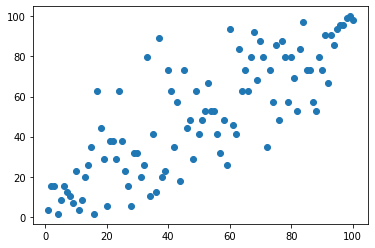

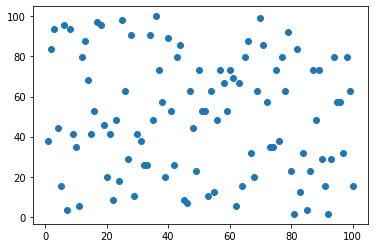

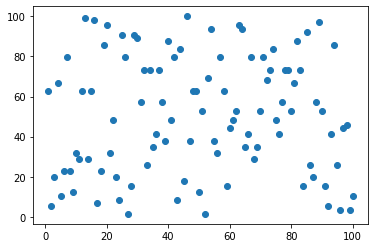

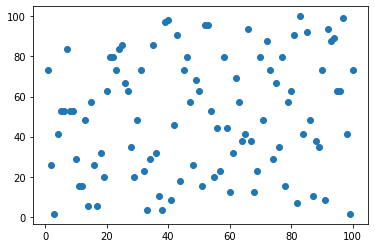

In [8]:
import matplotlib.pyplot as plt

plt.scatter(rank_confidences,rank_accs)
plt.show()

plt.scatter(rank_sensitivities,rank_accs)
plt.show()

plt.scatter(rank_robustnesses,rank_accs)
plt.show()

plt.scatter(rank_step_sims,rank_accs)
plt.show()

# Train a found model

In [9]:
trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
print(args)
args.save_dir = os.path.join(xargs.save_dir, "train")
print(args)

Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=24382, save_dir='./op_level-use_pretrain', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=24382, save_dir='./op_level-use_pretrain/train', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [10]:
print(config)

Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))


In [11]:
logger = prepare_logger(args)

# cifar_train_config_path = "./MY.config"
cifar_train_config_path = "../configs/nas-benchmark/CIFAR.config"
###
train_data, test_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)

train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

# search_loader, _, valid_loader = get_nas_search_loaders(train_data,
#                                                         valid_data,
#                                                         xargs.dataset,
#                                                         "../configs/nas-benchmark/",
#                                                         (config.batch_size, config.batch_size),
#                                                         xargs.workers)
logger.log("||||||| {:10s} ||||||| Train-Loader-Num={:}, Test-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(train_loader), len(test_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": True, # true for eval
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

### load
# trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
# search_model.load_state_dict(trained_output['model'], strict=False)
best_archs = trained_output['best_archs']
i=0
for m in search_model.modules():
    if isinstance(m, SearchCell):
        m.arch_cache = best_archs[i]
        i += 1
for m in network.modules():
    if isinstance(m, SearchCell):
        print(m.arch_cache)
###

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))

network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Main Function with logger : Logger(dir=op_level-use_pretrain/train, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 24382
save_dir         : ./op_level-use_pretrain/train
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/CIFAR.config
Configure(scheduler='cos', eta_min=0.0, epochs=200, warmup=0, optim='SGD', LR=0.1, decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', 

In [12]:
# def search_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
#     data_time, batch_time = AverageMeter(), AverageMeter()
#     base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
#     network.train()
#     end = time.time()
#     for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
#         xloader
#     ):
#         scheduler.update(None, 1.0 * step / len(xloader))
#         base_targets = base_targets.cuda(non_blocking=True)
#         arch_targets = arch_targets.cuda(non_blocking=True)
#         # measure data loading time
#         data_time.update(time.time() - end)

#         w_optimizer.zero_grad()
#         _, logits = network(base_inputs)
#         base_loss = criterion(logits, base_targets)
#         base_loss.backward()
#         nn.utils.clip_grad_norm_(network.parameters(), 5)
#         w_optimizer.step()
#         # record
#         base_prec1, base_prec5 = obtain_accuracy(
#             logits.data, base_targets.data, topk=(1, 5)
#         )
#         base_losses.update(base_loss.item(), base_inputs.size(0))
#         base_top1.update(base_prec1.item(), base_inputs.size(0))
#         base_top5.update(base_prec5.item(), base_inputs.size(0))

#         # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if step % print_freq == 0 or step + 1 == len(xloader):
#             Sstr = (
#                 "*SEARCH* "
#                 + time_string()
#                 + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
#             )
#             Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
#                 batch_time=batch_time, data_time=data_time
#             )
#             Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
#                 loss=base_losses, top1=base_top1, top5=base_top5
#             )
#             logger.log(Sstr + " " + Tstr + " " + Wstr)
#     return base_losses.avg, base_top1.avg, base_top5.avg

def train_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

#             network.module.random_genotype_per_cell(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [13]:
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = train_func_one_arch(
        train_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        test_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()


[Search the 000-200-th epoch] Time Left: [00:00:00], LR=0.1
*SEARCH* [2022-11-07 09:20:19] [000-200][000/196] Time 0.53 (0.53) Data 0.39 (0.39) Base [Loss 2.337 (2.337)  Prec@1 8.20 (8.20) Prec@5 52.34 (52.34)]
*SEARCH* [2022-11-07 09:20:53] [000-200][195/196] Time 0.16 (0.18) Data 0.00 (0.00) Base [Loss 1.443 (1.715)  Prec@1 41.25 (35.63) Prec@5 91.25 (86.63)]
[000-200] searching : loss=1.72, accuracy@1=35.63%, accuracy@5=86.63%, time-cost=34.4 s
[000-200] evaluate  : loss=1.88, accuracy@1=35.86%, accuracy@5=87.25%
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth
<<<--->>> The 000-200-th epoch : find the highest validation accuracy : 35.86%.
copy the file from op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth into op_level-use_pretrain/train/checkpoint/seed-24382-best.pth

[Search the 001-200-th epoch] Time Left: [02:09:22], LR=0.09999383162408304
*SEARCH* [2022-11-07 0

*SEARCH* [2022-11-07 09:25:18] [008-200][000/196] Time 0.56 (0.56) Data 0.41 (0.41) Base [Loss 0.690 (0.690)  Prec@1 75.00 (75.00) Prec@5 98.05 (98.05)]
*SEARCH* [2022-11-07 09:25:51] [008-200][195/196] Time 0.15 (0.17) Data 0.00 (0.00) Base [Loss 0.651 (0.677)  Prec@1 76.25 (76.51) Prec@5 98.75 (98.62)]
[008-200] searching : loss=0.68, accuracy@1=76.51%, accuracy@5=98.62%, time-cost=300.4 s
[008-200] evaluate  : loss=1.70, accuracy@1=51.35%, accuracy@5=94.53%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 009-200-th epoch] Time Left: [01:57:23], LR=0.09950118288582788
*SEARCH* [2022-11-07 09:25:55] [009-200][000/196] Time 0.57 (0.57) Data 0.40 (0.40) Base [Loss 0.733

[016-200] evaluate  : loss=1.02, accuracy@1=67.62%, accuracy@5=98.28%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 017-200-th epoch] Time Left: [01:58:40], LR=0.09822787092288991
*SEARCH* [2022-11-07 09:31:03] [017-200][000/196] Time 0.56 (0.56) Data 0.40 (0.40) Base [Loss 0.556 (0.556)  Prec@1 80.08 (80.08) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 09:31:37] [017-200][195/196] Time 0.25 (0.18) Data 0.00 (0.00) Base [Loss 0.639 (0.524)  Prec@1 75.00 (82.00) Prec@5 97.50 (99.21)]
[017-200] searching : loss=0.52, accuracy@1=82.00%, accuracy@5=99.21%, time-cost=610.7 s
[017-200] evaluate  : loss=0.80, accuracy@1=72.21%, accuracy@5=98.35%
Find op_level-use_pretrain/tra

*SEARCH* [2022-11-07 09:36:05] [025-200][000/196] Time 0.55 (0.55) Data 0.38 (0.38) Base [Loss 0.491 (0.491)  Prec@1 82.81 (82.81) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-07 09:36:40] [025-200][195/196] Time 0.14 (0.18) Data 0.00 (0.00) Base [Loss 0.446 (0.465)  Prec@1 83.75 (83.97) Prec@5 100.00 (99.33)]
[025-200] searching : loss=0.46, accuracy@1=83.97%, accuracy@5=99.33%, time-cost=881.9 s
[025-200] evaluate  : loss=0.84, accuracy@1=73.33%, accuracy@5=98.16%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 026-200-th epoch] Time Left: [01:53:43], LR=0.09588773128419906
*SEARCH* [2022-11-07 09:36:44] [026-200][000/196] Time 0.49 (0.49) Data 0.34 (0.34) Base [Loss 0.42

*SEARCH* [2022-11-07 09:42:21] [034-200][195/196] Time 0.10 (0.17) Data 0.00 (0.00) Base [Loss 0.332 (0.432)  Prec@1 86.25 (85.15) Prec@5 100.00 (99.38)]
[034-200] searching : loss=0.43, accuracy@1=85.15%, accuracy@5=99.38%, time-cost=1187.0 s
[034-200] evaluate  : loss=0.91, accuracy@1=71.60%, accuracy@5=97.40%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 035-200-th epoch] Time Left: [01:44:57], LR=0.09263200821770462
*SEARCH* [2022-11-07 09:42:25] [035-200][000/196] Time 0.65 (0.65) Data 0.46 (0.46) Base [Loss 0.411 (0.411)  Prec@1 87.89 (87.89) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 09:42:56] [035-200][195/196] Time 0.08 (0.16) Data 0.00 (0.00) Base [Loss 0.5

*SEARCH* [2022-11-07 09:47:25] [043-200][000/196] Time 0.55 (0.55) Data 0.37 (0.37) Base [Loss 0.413 (0.413)  Prec@1 87.50 (87.50) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-07 09:47:57] [043-200][195/196] Time 0.10 (0.17) Data 0.00 (0.00) Base [Loss 0.594 (0.405)  Prec@1 80.00 (86.05) Prec@5 98.75 (99.46)]
[043-200] searching : loss=0.41, accuracy@1=86.05%, accuracy@5=99.46%, time-cost=1485.9 s
[043-200] evaluate  : loss=0.58, accuracy@1=80.78%, accuracy@5=98.77%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 044-200-th epoch] Time Left: [01:38:04], LR=0.08852566213878947
*SEARCH* [2022-11-07 09:48:02] [044-200][000/196] Time 0.57 (0.57) Data 0.38 (0.38) Base [Loss 0.35

*SEARCH* [2022-11-07 09:53:06] [052-200][000/196] Time 0.76 (0.76) Data 0.43 (0.43) Base [Loss 0.268 (0.268)  Prec@1 91.02 (91.02) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 09:53:41] [052-200][195/196] Time 0.17 (0.18) Data 0.00 (0.00) Base [Loss 0.219 (0.383)  Prec@1 92.50 (86.74) Prec@5 100.00 (99.54)]
[052-200] searching : loss=0.38, accuracy@1=86.74%, accuracy@5=99.54%, time-cost=1792.5 s
[052-200] evaluate  : loss=0.60, accuracy@1=80.19%, accuracy@5=99.19%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 053-200-th epoch] Time Left: [01:37:29], LR=0.08365062567548867
*SEARCH* [2022-11-07 09:53:46] [053-200][000/196] Time 0.56 (0.56) Data 0.45 (0.45) Base [Loss 0

*SEARCH* [2022-11-07 09:58:50] [061-200][000/196] Time 0.67 (0.67) Data 0.38 (0.38) Base [Loss 0.413 (0.413)  Prec@1 85.55 (85.55) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 09:59:22] [061-200][195/196] Time 0.12 (0.17) Data 0.00 (0.00) Base [Loss 0.402 (0.360)  Prec@1 82.50 (87.40) Prec@5 100.00 (99.58)]
[061-200] searching : loss=0.36, accuracy@1=87.40%, accuracy@5=99.58%, time-cost=2097.5 s
[061-200] evaluate  : loss=0.76, accuracy@1=75.76%, accuracy@5=98.37%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 062-200-th epoch] Time Left: [01:24:46], LR=0.07810416889260655
*SEARCH* [2022-11-07 09:59:27] [062-200][000/196] Time 0.63 (0.63) Data 0.40 (0.40) Base [Loss 0.3

*SEARCH* [2022-11-07 10:05:08] [070-200][195/196] Time 0.13 (0.18) Data 0.00 (0.00) Base [Loss 0.497 (0.344)  Prec@1 83.75 (88.16) Prec@5 100.00 (99.67)]
[070-200] searching : loss=0.34, accuracy@1=88.16%, accuracy@5=99.67%, time-cost=2406.1 s
[070-200] evaluate  : loss=0.85, accuracy@1=73.45%, accuracy@5=98.44%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 071-200-th epoch] Time Left: [01:23:48], LR=0.07199695849279575
*SEARCH* [2022-11-07 10:05:12] [071-200][000/196] Time 0.54 (0.54) Data 0.40 (0.40) Base [Loss 0.341 (0.341)  Prec@1 89.06 (89.06) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-07 10:05:47] [071-200][195/196] Time 0.09 (0.18) Data 0.00 (0.00) Base [Loss 0.5

[079-200] evaluate  : loss=0.73, accuracy@1=78.18%, accuracy@5=98.06%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 080-200-th epoch] Time Left: [01:15:46], LR=0.06545084971874737
*SEARCH* [2022-11-07 10:10:58] [080-200][000/196] Time 0.58 (0.58) Data 0.38 (0.38) Base [Loss 0.317 (0.317)  Prec@1 90.23 (90.23) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 10:11:32] [080-200][195/196] Time 0.19 (0.18) Data 0.00 (0.00) Base [Loss 0.381 (0.317)  Prec@1 91.25 (89.08) Prec@5 97.50 (99.66)]
[080-200] searching : loss=0.32, accuracy@1=89.08%, accuracy@5=99.66%, time-cost=2748.2 s
[080-200] evaluate  : loss=0.63, accuracy@1=79.45%, accuracy@5=99.06%
Find op_level-use_pretrain/tr

*SEARCH* [2022-11-07 10:16:46] [088-200][195/196] Time 0.15 (0.18) Data 0.00 (0.00) Base [Loss 0.395 (0.301)  Prec@1 91.25 (89.66) Prec@5 98.75 (99.74)]
[088-200] searching : loss=0.30, accuracy@1=89.66%, accuracy@5=99.74%, time-cost=3028.9 s
[088-200] evaluate  : loss=0.51, accuracy@1=83.31%, accuracy@5=99.23%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 089-200-th epoch] Time Left: [01:12:40], LR=0.058596455013970476
*SEARCH* [2022-11-07 10:16:51] [089-200][000/196] Time 0.51 (0.51) Data 0.33 (0.33) Base [Loss 0.267 (0.267)  Prec@1 91.41 (91.41) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 10:17:25] [089-200][195/196] Time 0.12 (0.17) Data 0.00 (0.00) Base [Loss 0.2

[097-200] evaluate  : loss=0.53, accuracy@1=82.90%, accuracy@5=99.13%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 098-200-th epoch] Time Left: [01:03:34], LR=0.05157053795390642
*SEARCH* [2022-11-07 10:22:35] [098-200][000/196] Time 0.55 (0.55) Data 0.37 (0.37) Base [Loss 0.287 (0.287)  Prec@1 89.06 (89.06) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:23:07] [098-200][195/196] Time 0.13 (0.17) Data 0.00 (0.00) Base [Loss 0.373 (0.276)  Prec@1 87.50 (90.53) Prec@5 98.75 (99.74)]
[098-200] searching : loss=0.28, accuracy@1=90.53%, accuracy@5=99.74%, time-cost=3368.7 s
[098-200] evaluate  : loss=0.60, accuracy@1=81.64%, accuracy@5=98.82%
Find op_level-use_pretrain/

*SEARCH* [2022-11-07 10:27:36] [107-200][000/196] Time 0.54 (0.54) Data 0.34 (0.34) Base [Loss 0.258 (0.258)  Prec@1 91.02 (91.02) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:28:03] [107-200][195/196] Time 0.14 (0.14) Data 0.00 (0.00) Base [Loss 0.184 (0.256)  Prec@1 93.75 (91.23) Prec@5 100.00 (99.80)]
[107-200] searching : loss=0.26, accuracy@1=91.23%, accuracy@5=99.80%, time-cost=3629.6 s
[107-200] evaluate  : loss=0.60, accuracy@1=80.78%, accuracy@5=99.02%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 108-200-th epoch] Time Left: [00:48:07], LR=0.0437333383217848
*SEARCH* [2022-11-07 10:28:07] [108-200][000/196] Time 0.45 (0.45) Data 0.34 (0.34) Base [Loss 0.

*SEARCH* [2022-11-07 10:32:27] [116-200][000/196] Time 0.62 (0.62) Data 0.43 (0.43) Base [Loss 0.224 (0.224)  Prec@1 92.97 (92.97) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:32:57] [116-200][195/196] Time 0.17 (0.16) Data 0.00 (0.00) Base [Loss 0.246 (0.234)  Prec@1 91.25 (91.88) Prec@5 100.00 (99.85)]
[116-200] searching : loss=0.23, accuracy@1=91.88%, accuracy@5=99.85%, time-cost=3889.5 s
[116-200] evaluate  : loss=0.46, accuracy@1=85.58%, accuracy@5=99.37%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 117-200-th epoch] Time Left: [00:47:28], LR=0.03680634750173136
*SEARCH* [2022-11-07 10:33:01] [117-200][000/196] Time 0.67 (0.67) Data 0.33 (0.33) Base [Loss 0

*SEARCH* [2022-11-07 10:37:30] [125-200][000/196] Time 0.56 (0.56) Data 0.35 (0.35) Base [Loss 0.191 (0.191)  Prec@1 94.14 (94.14) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-07 10:37:57] [125-200][195/196] Time 0.16 (0.14) Data 0.00 (0.00) Base [Loss 0.324 (0.208)  Prec@1 87.50 (92.79) Prec@5 100.00 (99.87)]
[125-200] searching : loss=0.21, accuracy@1=92.79%, accuracy@5=99.87%, time-cost=4155.5 s
[125-200] evaluate  : loss=0.39, accuracy@1=87.40%, accuracy@5=99.39%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth
<<<--->>> The 125-200-th epoch : find the highest validation accuracy : 87.40%.
Find op_level-use_pretrain/train/checkpoint/seed-24382-best.pth exist, delete is at first befor

[133-200] evaluate  : loss=0.38, accuracy@1=88.10%, accuracy@5=99.60%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth
<<<--->>> The 133-200-th epoch : find the highest validation accuracy : 88.10%.
Find op_level-use_pretrain/train/checkpoint/seed-24382-best.pth exist, delete is at first before saving
copy the file from op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth into op_level-use_pretrain/train/checkpoint/seed-24382-best.pth

[Search the 134-200-th epoch] Time Left: [00:34:57], LR=0.024547929212481435
*SEARCH* [2022-11-07 10:42:15] [134-200][000/196] Time 0.50 (0.50) Data 0.38 (0.38) Base [Loss 0.173 (0.173)  Prec@1 94.92 (94.92) Prec@5 100.00 (100.00)]
*SEARCH* [20

*SEARCH* [2022-11-07 10:46:28] [142-200][000/196] Time 0.58 (0.58) Data 0.33 (0.33) Base [Loss 0.190 (0.190)  Prec@1 93.36 (93.36) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:46:55] [142-200][195/196] Time 0.14 (0.14) Data 0.00 (0.00) Base [Loss 0.199 (0.151)  Prec@1 92.50 (94.73) Prec@5 100.00 (99.94)]
[142-200] searching : loss=0.15, accuracy@1=94.73%, accuracy@5=99.94%, time-cost=4629.6 s
[142-200] evaluate  : loss=0.44, accuracy@1=87.03%, accuracy@5=99.43%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 143-200-th epoch] Time Left: [00:30:42], LR=0.01873786718321474
*SEARCH* [2022-11-07 10:47:00] [143-200][000/196] Time 0.56 (0.56) Data 0.37 (0.37) Base [Loss 0

*SEARCH* [2022-11-07 10:51:13] [151-200][000/196] Time 0.57 (0.57) Data 0.42 (0.42) Base [Loss 0.112 (0.112)  Prec@1 95.31 (95.31) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:51:38] [151-200][195/196] Time 0.10 (0.13) Data 0.00 (0.00) Base [Loss 0.077 (0.116)  Prec@1 98.75 (95.98) Prec@5 100.00 (99.96)]
[151-200] searching : loss=0.12, accuracy@1=95.98%, accuracy@5=99.96%, time-cost=4879.9 s
[151-200] evaluate  : loss=0.39, accuracy@1=88.50%, accuracy@5=99.57%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 152-200-th epoch] Time Left: [00:23:32], LR=0.013551568628929435
*SEARCH* [2022-11-07 10:51:42] [152-200][000/196] Time 0.45 (0.45) Data 0.33 (0.33) Base [Loss 

*SEARCH* [2022-11-07 10:56:05] [160-200][000/196] Time 0.59 (0.59) Data 0.37 (0.37) Base [Loss 0.087 (0.087)  Prec@1 97.27 (97.27) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 10:56:30] [160-200][195/196] Time 0.09 (0.13) Data 0.00 (0.00) Base [Loss 0.164 (0.084)  Prec@1 96.25 (97.11) Prec@5 100.00 (99.98)]
[160-200] searching : loss=0.08, accuracy@1=97.11%, accuracy@5=99.98%, time-cost=5137.6 s
[160-200] evaluate  : loss=0.37, accuracy@1=89.64%, accuracy@5=99.59%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 161-200-th epoch] Time Left: [00:19:55], LR=0.009092514128748836
*SEARCH* [2022-11-07 10:56:35] [161-200][000/196] Time 0.55 (0.55) Data 0.43 (0.43) Base [Loss 

[168-200] evaluate  : loss=0.36, accuracy@1=90.50%, accuracy@5=99.71%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth
<<<--->>> The 168-200-th epoch : find the highest validation accuracy : 90.50%.
Find op_level-use_pretrain/train/checkpoint/seed-24382-best.pth exist, delete is at first before saving
copy the file from op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth into op_level-use_pretrain/train/checkpoint/seed-24382-best.pth

[Search the 169-200-th epoch] Time Left: [00:17:02], LR=0.005811718495565327
*SEARCH* [2022-11-07 11:00:57] [169-200][000/196] Time 0.55 (0.55) Data 0.41 (0.41) Base [Loss 0.044 (0.044)  Prec@1 98.44 (98.44) Prec@5 100.00 (100.00)]
*SEARCH* [20

*SEARCH* [2022-11-07 11:04:40] [176-200][000/196] Time 0.55 (0.55) Data 0.42 (0.42) Base [Loss 0.034 (0.034)  Prec@1 99.22 (99.22) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:05:11] [176-200][195/196] Time 0.13 (0.16) Data 0.00 (0.00) Base [Loss 0.133 (0.032)  Prec@1 96.25 (99.04) Prec@5 100.00 (100.00)]
[176-200] searching : loss=0.03, accuracy@1=99.04%, accuracy@5=100.00%, time-cost=5595.3 s
[176-200] evaluate  : loss=0.35, accuracy@1=91.41%, accuracy@5=99.73%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth
<<<--->>> The 176-200-th epoch : find the highest validation accuracy : 91.41%.
Find op_level-use_pretrain/train/checkpoint/seed-24382-best.pth exist, delete is at first b

*SEARCH* [2022-11-07 11:08:53] [184-200][000/196] Time 0.44 (0.44) Data 0.32 (0.32) Base [Loss 0.025 (0.025)  Prec@1 99.22 (99.22) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:09:20] [184-200][195/196] Time 0.16 (0.14) Data 0.00 (0.00) Base [Loss 0.022 (0.020)  Prec@1 100.00 (99.46) Prec@5 100.00 (100.00)]
[184-200] searching : loss=0.02, accuracy@1=99.46%, accuracy@5=100.00%, time-cost=5816.6 s
[184-200] evaluate  : loss=0.33, accuracy@1=92.03%, accuracy@5=99.72%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth
<<<--->>> The 184-200-th epoch : find the highest validation accuracy : 92.03%.
Find op_level-use_pretrain/train/checkpoint/seed-24382-best.pth exist, delete is at first 

*SEARCH* [2022-11-07 11:13:39] [193-200][000/196] Time 0.59 (0.59) Data 0.35 (0.35) Base [Loss 0.038 (0.038)  Prec@1 98.44 (98.44) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-07 11:14:04] [193-200][195/196] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.023 (0.015)  Prec@1 100.00 (99.68) Prec@5 100.00 (100.00)]
[193-200] searching : loss=0.01, accuracy@1=99.68%, accuracy@5=100.00%, time-cost=6067.7 s
[193-200] evaluate  : loss=0.33, accuracy@1=91.87%, accuracy@5=99.73%
Find op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/checkpoint/seed-24382-basic.pth
Find op_level-use_pretrain/train/seed-24382-last-info.pth exist, delete is at first before saving
save checkpoint into op_level-use_pretrain/train/seed-24382-last-info.pth

[Search the 194-200-th epoch] Time Left: [00:02:54], LR=0.0002219017698460002
*SEARCH* [2022-11-07 11:14:08] [194-200][000/196] Time 0.51 (0.51) Data 0.36 (0.36) Base [L

In [14]:
best_archs

[Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|),
 Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|),
 Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_3x3~2|),
 Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_1x1~2|),
 Structure(4 nodes with |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_3x3~2|),
 Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|skip_connect~2|),
 Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|avg_pool_3x3~2|),
 Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|),
 Structure(4 nodes with |nor_conv_3x3~0|+|avg_po